<a href="https://colab.research.google.com/github/Al-Asl/RegexInference/blob/main/Paresy_S.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <strong>Initialization</strong>

To begin, please run the code below to transfer all of the necessary requirements, including the codes, dependencies, benchmarks, etc, to this notebook.

In [ ]:
! git clone --recursive https://github.com/Al-Asl/RegexInference.git

# <strong>GPU version of the algorithm</strong>

**Important:** To optimize memory and performance, we recommend upgrading your Colab to `Pro` or `Pro+` versions. These paid versions offer larger memory limits, faster processing speeds, and advanced hardware acceleration, enabling users to execute complex operations with greater efficiency. By contrast, the `free version` of Colab may be subject to limitations that can impact the performance and accuracy of the following tasks.

**To upgrade to Colab Pro:**

- Find the `Colab Pro` tab in `Tools > Settings`.
- Choose your desired plan: `Colab Pro` or `Colab Pro+`.
- Follow the prompts to enter your billing information and complete the purchase process.

**Note:** Colab Pro is billed on a monthly basis, and you can cancel at any time. Additionally, some countries or regions may not be eligible to purchase Colab Pro at this time, so you may need to check if it is available in your area before proceeding.

**Note:** To run a cell in Colab, you can either click on the "play" button located on the left side of the cell, or you can press "Shift+Enter" on your keyboard while the cell is selected.

<div class="markdown-google-sans">
<h1>Compiling</h1>
</div>

To compile and run the GPU code, please run the following scripts.

**NOTE:** You can configure `-D EVALUATION_MODE`, `-D GUIDE_TABLE_CONSTANT_MEMORY`, `-D LOG_LEVEL`, `-D CS_BIT_COUNT `

In [ ]:
%cd "/content/RegexInference/Paresy-S/"
! mkdir build
%cd build
! cmake -D CS_BIT_COUNT=128 -D EVALUATION_MODE=ON ..
! make

<div class="markdown-google-sans">
<h1>Running the GPU code</h1>
</div>

Generally, you can use
```
! /content/RegexInference/Paresy-S/build/Paresy-S <input_file_address> <dc_type> <window_size> <max_time> <c1> <c2> <c3> <c4> <c5> <maxCost>
```
where
1. `input_file_address` refers to the address of the input file that contains your positive and negative examples.
2. `dc_type` Specifies the type of divide-and-conquer algorithm to use. A value of 1 represents a random split, while a value of 2 indicates a deterministic split.
3. `window_size` Defines the maximum number of examples that can be passed to the GPU at once.
4. `max_time` Sets the time limit (in seconds) for each individual call to the GPU.
5. (`c1`, `c2`, `c3`, `c4`, `c5`) are 5 small positive integers for the costs of (a, ?, *, ., +)
6. `maxCost` parameter is an integer that sets an upper limit on the cost of the regular expression that the algorithm will search for. In most cases, you can use a reasonably large integer, such as 500, which is appropriate for our cost functions.

For example, to run the first example of `type1` in our benchmarks, use the code below.

In [ ]:
! '/content/RegexInference/Paresy-S/build/Paresy-S' '/content/RegexInference/Benchmarks/dc/dc_exp1.txt' 1 16 60 50 1 1 1 1 1 500

<div class="markdown-google-sans">
<h1>Mesurement</h1>
</div>

In [ ]:
import csv
import subprocess
import os
import re
import math

class ParesyArguments:
    dc_type :int        = 1
    window_size: int    = 20
    max_time : float    = 60
    train_ratio:int     = 50
    alpha_cost :int     = 1
    question_cost :int  = 1
    star_cost :int      = 1
    concat_cost :int    = 1
    or_cost :int        = 1
    max_cost :int       = 500

def get_lines_count(file_path):
    try:
        with open(file_path, 'r') as file:
            return sum(1 for line in file)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

def run(exc_path, file_path, arguments: ParesyArguments):
    command = [exc_path, file_path, str(arguments.dc_type), str(arguments.window_size), str(arguments.max_time), str(arguments.train_ratio) , str(arguments.alpha_cost), str(arguments.question_cost), str(arguments.star_cost), str(arguments.concat_cost), str(arguments.or_cost), str(arguments.max_cost)]

    try:
        result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        output = result.stdout

        cost_final_match = re.search(r"Final Cost:\s*([\d.]+)", output)
        runtime_match = re.search(r"Running Time:\s*([\d.]+)", output)
        call_count_match = re.search(r"Call count:\s*([\d.]+)", output)
        max_depth_match = re.search(r"Max depth:\s*([\d.]+)", output)
        precision_match = re.search(r"Precision=\s*([\d.]+)", output)
        recall_match = re.search(r"Recall=\s*([\d.]+)", output)
        f1_match = re.search(r"F1-score=\s*([\d.]+)", output)
        regex_match = re.search(r'RE:\s*"(.*?)"', output)

        cost_final = cost_final_match.group(1) if cost_final_match else ""
        runtime = float(runtime_match.group(1)) if runtime_match else ""
        call_count = call_count_match.group(1) if call_count_match else ""
        max_depth = max_depth_match.group(1) if max_depth_match else ""
        precision = precision_match.group(1) if precision_match else ""
        recall = recall_match.group(1) if recall_match else ""
        f1 = f1_match.group(1) if f1_match else ""
        regex = regex_match.group(1) if regex_match else ""

        return [cost_final, call_count, max_depth, runtime, precision, recall, f1, regex]

    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

def run_benchmarks(dir_path, output_csv):
    with open(output_csv, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Index", "Window", "DC Type" ,"Cost of Final RE", "Call Count", "Max Depth", "Running Time", "Precision", "Recall", "F1", "RE"])

    for dc_type in [1, 2]:
        for window in range(32, 4, -1):
            arguments = ParesyArguments()
            arguments.dc_type = dc_type
            arguments.window_size = window
            for file_name in os.listdir(dir_path):
              if file_name.endswith(".txt"):
                  file_path = os.path.join(dir_path, file_name)

              print(f"running {file_name} with window size {window} and dc_type {dc_type}")
              i = re.search(r"exp([\d]*)", file_name).group(1)
              row = run("/content/RegexInference/Paresy-S/build/Paresy-S", file_path, arguments)
              row = [i, window, dc_type] + row

              with open(output_csv, mode='a', newline='') as f:
                writer = csv.writer(f)
                writer.writerow(row)

run_benchmarks("/content/RegexInference/Benchmarks/dc", "/content/RegexInference/Benchmarks/benchmarks_results.csv")

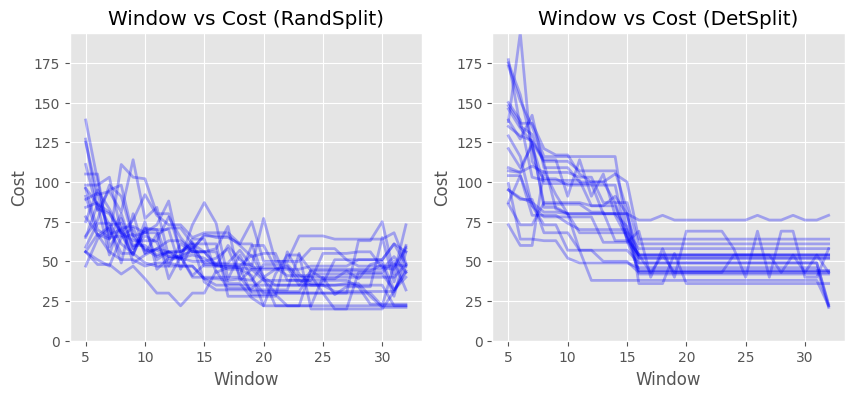

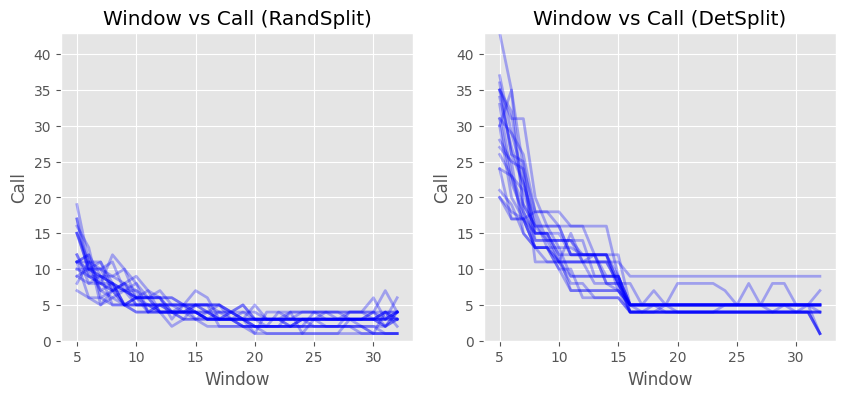

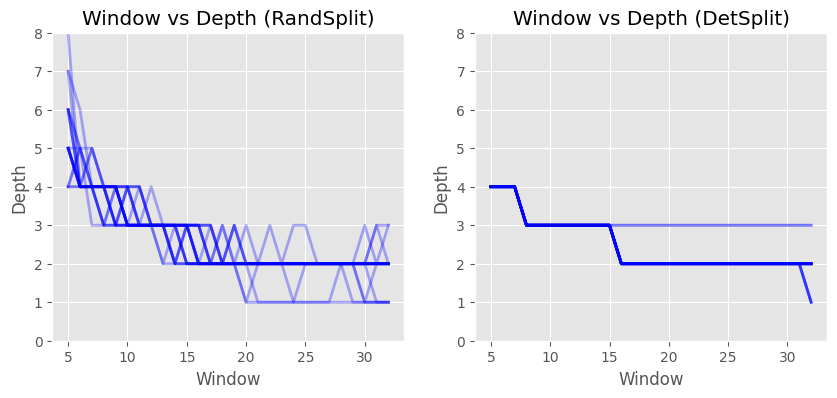

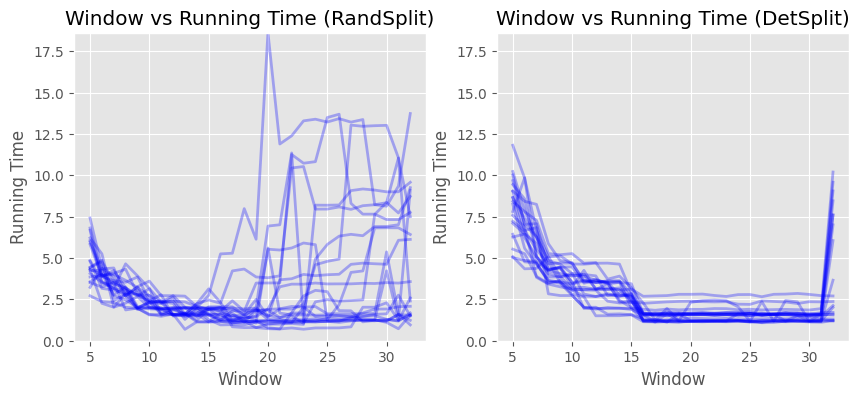

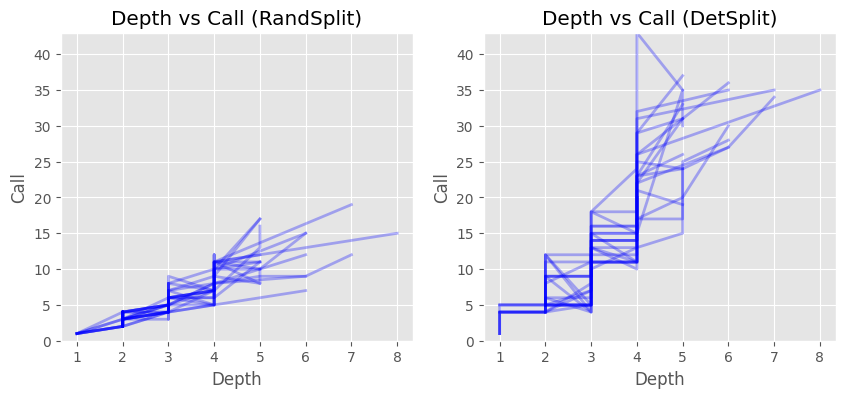

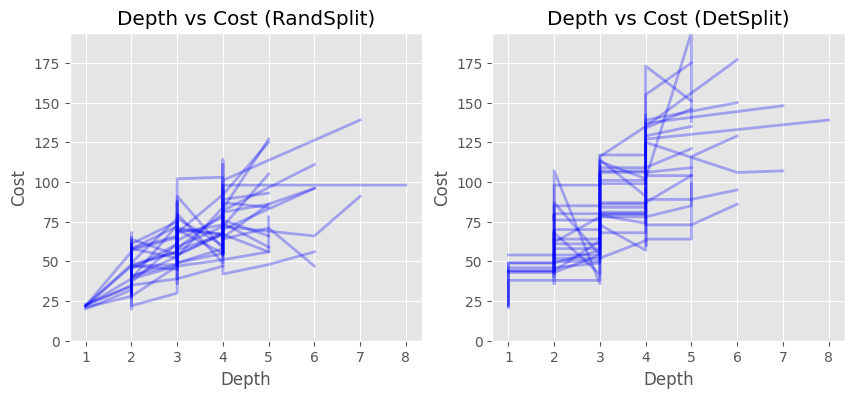

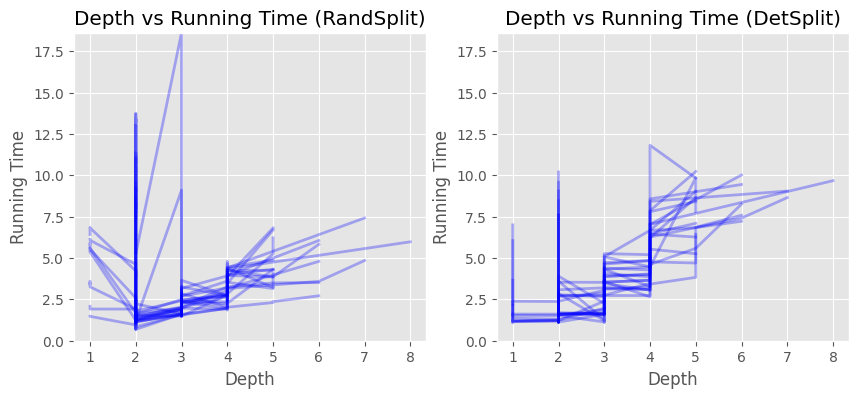

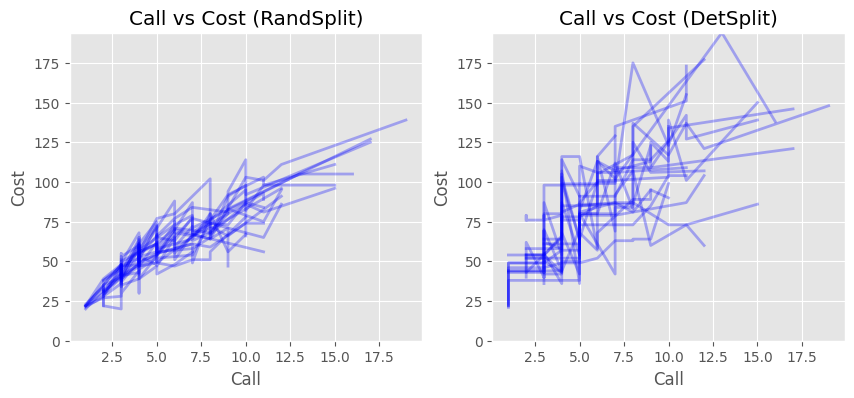

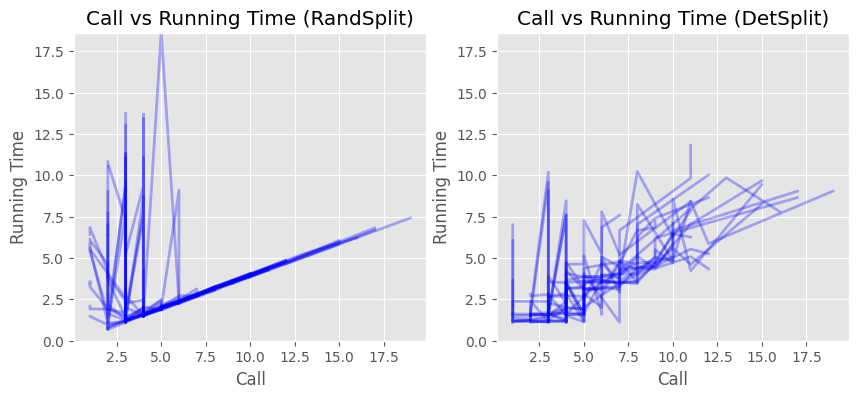

In [ ]:
import csv
import matplotlib.pyplot as plt

data = []

with open('/content/RegexInference/Benchmarks/benchmarks_results.csv', 'r', newline='') as file:
    reader = csv.reader(file)
    next(reader)
    for row in reader:
        data.append(row)

def draw_lines(x_index, y_index):
  fig, axes = plt.subplots(1, 2, figsize=(10, 4))
  labels = ["Index", "Window", "DC Type" ,"Cost", "Call", "Depth", "Running Time", "Precision", "Recall", "F1", "RE"]
  y_max = -1000000000
  for index in range(1,21):
    points = [(item[x_index], item[y_index], item[2]) for item in data if item[0] == f'{index}']
    x  = [item[x_index] for item in data if item[0] == f'{index}' and item[2] == '1']
    y1 = [item[y_index] for item in data if item[0] == f'{index}' and item[2] == '1']
    y2 = [item[y_index] for item in data if item[0] == f'{index}' and item[2] == '2']

    x = list(map(int,x))
    y1 = list(map(float,y1))
    y2 = list(map(float,y2))

    sorted = list(zip(x, y1, y2))
    sorted.sort(key=lambda e: e[0])
    x, y1, y2 = zip(*sorted)

    y_max = max(y_max, max(y1))
    y_max = max(y_max, max(y2))

    axes[0].plot(x, y1, color='blue', alpha=0.3, linewidth=2)
    axes[1].plot(x, y2, color='blue', alpha=0.3, linewidth=2)

  title = f"{labels[x_index]} vs {labels[y_index]}"
  axes[0].set_ylim(0, y_max)
  axes[0].set_xlabel(labels[x_index])
  axes[0].set_ylabel(labels[y_index])
  axes[0].set_title(title + ' (RandSplit)')

  axes[1].set_ylim(0, y_max)
  axes[1].set_xlabel(labels[x_index])
  axes[1].set_ylabel(labels[y_index])
  axes[1].set_title(title + ' (DetSplit)')
  plt.style.use('ggplot')
  plt.show()

draw_lines(1,3)
draw_lines(1,4)
draw_lines(1,5)
draw_lines(1,6)

draw_lines(5,4)
draw_lines(5,3)
draw_lines(5,6)

draw_lines(4,3)
draw_lines(4,6)